<a href="https://colab.research.google.com/github/dinus123/Colab/blob/main/Python_Code_for_Comprehensive_Negative_Year_and_Loss_Likelihood_Analysis_(Refactored_%26_Expanded).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy import stats
import time
import matplotlib.pyplot as plt
import io

# Set a random seed for reproducibility
np.random.seed(42)


In [2]:

# --- Functions for Return Generation ---
def generate_returns(dist_type, num_periods, mean_return=0.0, std_dev_return=0.01, df=None):
    """Generates daily returns based on the specified distribution."""
    if dist_type == 'normal':
        return np.random.normal(loc=mean_return, scale=std_dev_return, size=num_periods)
    elif dist_type == 'lognormal':
        if mean_return <= -1.0:
             return np.full(num_periods, -0.9999999)

        target_mean_arith = mean_return
        target_std_arith = std_dev_return
        E_1_plus_R = 1.0 + target_mean_arith
        Var_R = target_std_arith**2

        if E_1_plus_R <= 1e-9:
            return np.full(num_periods, -0.9999999) if target_std_arith >= 1e-9 else np.full(num_periods, -1.0)

        # sigma_log_sq must be positive for np.sqrt
        sigma_log_sq_arg = 1.0 + Var_R / (E_1_plus_R**2)
        if sigma_log_sq_arg <= 1e-12:
            sigma_log_sq = 1e-12
        else:
            sigma_log_sq = np.log(sigma_log_sq_arg)
            if sigma_log_sq <= 1e-12:
                 sigma_log_sq = 1e-12

        mu_log = np.log(E_1_plus_R) - sigma_log_sq / 2.0

        log_returns = np.random.normal(loc=mu_log, scale=np.sqrt(sigma_log_sq), size=num_periods)
        arithmetic_returns = np.exp(log_returns) - 1.0
        return np.maximum(arithmetic_returns, -0.9999999)

    elif dist_type == 'student_t':
        if df is None or df <= 2:
            raise ValueError("Degrees of freedom (df) must be greater than 2 for Student-T with defined variance.")
        variance_return = std_dev_return**2
        scale_param = np.sqrt(variance_return * (df - 2.0) / df)
        return stats.t.rvs(df=df, loc=mean_return, scale=scale_param, size=num_periods)
    else:
        raise ValueError(f"Unknown distribution type: {dist_type}")

# --- Function to Calculate Annual Returns (Vectorized for 1D daily returns input) ---
def calculate_annual_returns_from_daily(daily_returns_1d, num_years, days_per_year):
    """Calculates annual returns from a 1D sequence of daily returns for multiple years."""
    actual_total_days = len(daily_returns_1d)
    num_full_years = actual_total_days // days_per_year

    if num_full_years == 0:
        return np.array([]) # No full years to process

    # Trim to only include full years
    trimmed_daily_returns = daily_returns_1d[:num_full_years * days_per_year]

    # Reshape into (num_full_years, days_per_year)
    daily_returns_2d = trimmed_daily_returns.reshape(num_full_years, days_per_year)

    # Calculate annual returns: product over days_per_year axis
    annual_returns = np.prod(1.0 + np.maximum(daily_returns_2d, -0.9999999), axis=1) - 1.0
    return annual_returns

# --- Function to Calculate Terminal Wealth ---
def calculate_terminal_wealth(daily_returns_sequence, initial_wealth=1.0):
    if not daily_returns_sequence.size: # Check if array is empty
        return initial_wealth
    return initial_wealth * np.prod(1.0 + np.maximum(daily_returns_sequence, -0.9999999))

# --- Function to get equity curve and HWM (High Water Mark) ---
def get_equity_curve_and_hwm(daily_returns, initial_wealth=1.0):
    processed_returns = np.maximum(daily_returns, -0.9999999)
    # Equity curve includes the initial wealth point
    equity_curve = np.concatenate(([initial_wealth], initial_wealth * np.cumprod(1.0 + processed_returns)))
    high_water_mark = np.maximum.accumulate(equity_curve)
    return equity_curve, high_water_mark

# --- Function to calculate daily drawdown series (positive values) ---
def calculate_daily_drawdown_series_positive(equity_curve, high_water_mark):
    # Ensure HWM is not zero to avoid division by zero; add small epsilon.
    # HWM should be positive if initial_wealth is positive and returns are capped.
    drawdown_pct = (high_water_mark - equity_curve) / (high_water_mark + 1e-12)
    return drawdown_pct[1:] # Exclude drawdown at t=0 (which is 0)

# --- Function to calculate CVaR ---
def calculate_cvar(returns_series, alpha=0.05):
    if not returns_series.size: return np.nan
    # Ensure returns_series is a NumPy array for sorting
    if not isinstance(returns_series, np.ndarray):
        returns_series = np.array(returns_series)
    sorted_returns = np.sort(returns_series)
    index = int(alpha * len(sorted_returns))
    if index == 0: # Handle case where alpha*len is < 1, meaning less than 1 element for CVaR
        if len(sorted_returns) > 0:
            return sorted_returns[0] # Return the worst loss if alpha is too small for multiple elements
        else:
            return np.nan # No returns to calculate CVaR from
    return np.mean(sorted_returns[:index])


# --- Function to find longest run of negative numbers ---
def get_longest_run_negative(series):
    if not series.size: return 0
    max_run = current_run = 0
    for x in series:
        if x < 0:
            current_run += 1
        else:
            max_run = max(max_run, current_run)
            current_run = 0
    max_run = max(max_run, current_run) # Final check
    return max_run


In [3]:

# === Main Simulation Configuration ===
num_years_per_run = 10
num_trading_days_per_year = 252
num_total_daily_periods_per_run = num_trading_days_per_year * num_years_per_run
num_monte_carlo_sims = 10000

fixed_annual_std_dev_config = 0.15
mean_returns_to_test_annual = np.array([0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
fixed_15_pct_mean_annual = 0.15

distributions_to_analyze = [
    {'name': 'Normal', 'dist_type': 'normal', 'df': None},
    {'name': 'Student-T (df=5)', 'dist_type': 'student_t', 'df': 5},
    {'name': 'Log-Normal', 'dist_type': 'lognormal', 'df': None},
    {'name': 'Student-T (df=3)', 'dist_type': 'student_t', 'df': 3}
]
dist_names_for_header = [d['name'] for d in distributions_to_analyze]

# --- Initialize Storage for Results ---
prob_any_year_negative_fixed_mean = {dist['name']: 0.0 for dist in distributions_to_analyze}
sequential_neg_years_counts_varied_mean = {
    dist['name']: { f"{m*100:.0f}%": np.zeros(num_years_per_run, dtype=int) for m in mean_returns_to_test_annual }
    for dist in distributions_to_analyze
}
prob_year1_neg_vs_mean_for_graph = { dist['name']: np.zeros(len(mean_returns_to_test_annual)) for dist in distributions_to_analyze }
wealth_below_initial_counts = {
    dist['name']: { f"{m*100:.0f}%": {N_years: 0 for N_years in [1, 3, 5, 10]} for m in mean_returns_to_test_annual }
    for dist in distributions_to_analyze
}
prob_in_drawdown_at_year_end_counts = {
    dist['name']: { f"{m*100:.0f}%": np.zeros(num_years_per_run, dtype=int) for m in mean_returns_to_test_annual }
    for dist in distributions_to_analyze
}
prob_in_dd_year1_vs_mean_for_graph = { dist['name']: np.zeros(len(mean_returns_to_test_annual)) for dist in distributions_to_analyze }
drawdown_size_thresholds_for_table5 = np.arange(0, 0.5001, 0.05)
days_in_drawdown_by_size_sum_normal = {
    f"{m*100:.0f}%": np.zeros(len(drawdown_size_thresholds_for_table5)) for m in mean_returns_to_test_annual
}

# NEW Storage for Tables 6, 7, 8
all_annual_returns_for_cvar = {
    dist['name']: { f"{m*100:.0f}%": [] for m in mean_returns_to_test_annual } # Store lists of all annual returns
    for dist in distributions_to_analyze
}
longest_neg_run_all_sims = {
    dist['name']: { f"{m*100:.0f}%": np.zeros(num_monte_carlo_sims, dtype=int) for m in mean_returns_to_test_annual }
    for dist in distributions_to_analyze
}
max_dd_thresholds_table8 = np.array([0.20, 0.30, 0.40])
prob_max_dd_exceeds_thresh_counts = {
    dist['name']: {
        f"{m*100:.0f}%": np.zeros(len(max_dd_thresholds_table8), dtype=int) for m in mean_returns_to_test_annual
    } for dist in distributions_to_analyze
}

total_year_instances_for_fixed_mean_table1 = num_monte_carlo_sims * num_years_per_run

print(f"--- Starting Comprehensive Monte Carlo Simulation ---")
print(f"Distributions: {dist_names_for_header}")
print(f"Fixed Annual Std Dev: {fixed_annual_std_dev_config*100:.0f}%")
print(f"Annual Means to test: {[f'{m*100:.0f}%' for m in mean_returns_to_test_annual]}")
print(f"Simulations per scenario: {num_monte_carlo_sims}")
overall_start_time = time.time()

# --- Main Simulation Loop (Consolidated) ---
for dist_spec in distributions_to_analyze:
    dist_name = dist_spec['name']
    print(f"\nProcessing Distribution: {dist_name}...")
    dist_start_time = time.time()

    num_negative_years_for_fixed_15pct_mean_this_dist = 0

    for i_mean, annual_mean_val in enumerate(mean_returns_to_test_annual):
        mean_key = f"{annual_mean_val*100:.0f}%"
        periodic_mean = annual_mean_val / num_trading_days_per_year
        periodic_std_dev = fixed_annual_std_dev_config / np.sqrt(num_trading_days_per_year)

        if i_mean == 0: print(f"    Starting simulations for varying means (Mean={mean_key})...")
        elif (i_mean + 1) % 3 == 0: print(f"      ...continuing for Mean={mean_key}...")

        for sim_idx in range(num_monte_carlo_sims):
            daily_returns_sim = generate_returns(
                dist_type=dist_spec['dist_type'], num_periods=num_total_daily_periods_per_run,
                mean_return=periodic_mean, std_dev_return=periodic_std_dev, df=dist_spec['df']
            )
            annual_returns_sim = calculate_annual_returns_from_daily(
                daily_returns_sim, num_years_per_run, num_trading_days_per_year
            )

            if not annual_returns_sim.size: continue

            # Table 1 accumulation
            if annual_mean_val == fixed_15_pct_mean_annual:
                num_negative_years_for_fixed_15pct_mean_this_dist += np.sum(annual_returns_sim < 0)

            # Table 2 & Graph 1
            if annual_returns_sim[0] < 0:
                prob_year1_neg_vs_mean_for_graph[dist_name][i_mean] += 1
            all_prev_neg = True
            for k_year in range(len(annual_returns_sim)):
                if all_prev_neg and annual_returns_sim[k_year] < 0:
                    sequential_neg_years_counts_varied_mean[dist_name][mean_key][k_year] += 1
                else: all_prev_neg = False

            # Table 3
            for N_years_check in [1, 3, 5, 10]:
                if N_years_check <= len(annual_returns_sim):
                    idx_end_daily = N_years_check * num_trading_days_per_year
                    daily_returns_subset = daily_returns_sim[:idx_end_daily]
                    if daily_returns_subset.size > 0:
                         terminal_wealth = calculate_terminal_wealth(daily_returns_subset)
                         if terminal_wealth < 1.0:
                             wealth_below_initial_counts[dist_name][mean_key][N_years_check] += 1

            equity_curve, high_water_mark = get_equity_curve_and_hwm(daily_returns_sim)
            # Table 4 & Graph 2
            year_end_indices_ec = (np.arange(1, num_years_per_run + 1) * num_trading_days_per_year).astype(int)
            valid_year_end_indices_ec = year_end_indices_ec[year_end_indices_ec < len(equity_curve)]
            if valid_year_end_indices_ec.size > 0:
                in_dd_at_year_ends = equity_curve[valid_year_end_indices_ec] < high_water_mark[valid_year_end_indices_ec] - 1e-9
                for k_idx, is_in_dd in enumerate(in_dd_at_year_ends):
                    if is_in_dd: prob_in_drawdown_at_year_end_counts[dist_name][mean_key][k_idx] += 1
                if in_dd_at_year_ends.size > 0 and in_dd_at_year_ends[0]: # Check size before indexing
                     prob_in_dd_year1_vs_mean_for_graph[dist_name][i_mean] +=1

            # Table 5
            if dist_name == 'Normal':
                daily_dd_series = calculate_daily_drawdown_series_positive(equity_curve, high_water_mark)
                if daily_dd_series.size > 0:
                    counts_at_thresholds = np.sum(daily_dd_series[:, np.newaxis] >= (drawdown_size_thresholds_for_table5[np.newaxis, :] - 1e-9), axis=0)
                    days_in_drawdown_by_size_sum_normal[mean_key] += (counts_at_thresholds / len(daily_dd_series)) * 100.0

            # NEW: Accumulate for Table 6 (CVaR)
            all_annual_returns_for_cvar[dist_name][mean_key].extend(annual_returns_sim)

            # NEW: Accumulate for Table 7 (Longest Negative Run)
            longest_neg_run_all_sims[dist_name][mean_key][sim_idx] = get_longest_run_negative(annual_returns_sim)

            # NEW: Accumulate for Table 8 (Prob Max DD > X%)
            # Recompute daily_dd_series if not Normal distribution, or if not computed yet
            if dist_name != 'Normal' or 'daily_dd_series' not in locals() or daily_dd_series.size == 0:
                daily_dd_series_t8 = calculate_daily_drawdown_series_positive(equity_curve, high_water_mark)
            elif dist_name == 'Normal':
                 daily_dd_series_t8 = daily_dd_series

            if daily_dd_series_t8.size > 0:
                max_dd_this_sim = np.max(daily_dd_series_t8)
                for thresh_idx_t8, dd_thresh_t8 in enumerate(max_dd_thresholds_table8):
                    if max_dd_this_sim >= dd_thresh_t8 - 1e-9 :
                        prob_max_dd_exceeds_thresh_counts[dist_name][mean_key][thresh_idx_t8] += 1

    if total_year_instances_for_fixed_mean_table1 > 0:
        prob_any_year_negative_fixed_mean[dist_name] = \
            (num_negative_years_for_fixed_15pct_mean_this_dist / total_year_instances_for_fixed_mean_table1) * 100.0
    else: prob_any_year_negative_fixed_mean[dist_name] = 0.0

    dist_end_time = time.time()
    print(f"  Distribution {dist_name} completed in {dist_end_time - dist_start_time:.2f}s.")

overall_end_time = time.time()
print(f"\n--- All Monte Carlo Simulations Completed in {overall_end_time - overall_start_time:.2f} seconds ---")


--- Starting Comprehensive Monte Carlo Simulation ---
Distributions: ['Normal', 'Student-T (df=5)', 'Log-Normal', 'Student-T (df=3)']
Fixed Annual Std Dev: 15%
Annual Means to test: ['0%', '5%', '10%', '15%', '20%', '25%', '30%']
Simulations per scenario: 10000

Processing Distribution: Normal...
    Starting simulations for varying means (Mean=0%)...
      ...continuing for Mean=10%...
      ...continuing for Mean=25%...
  Distribution Normal completed in 46.93s.

Processing Distribution: Student-T (df=5)...
    Starting simulations for varying means (Mean=0%)...
      ...continuing for Mean=10%...
      ...continuing for Mean=25%...
  Distribution Student-T (df=5) completed in 39.11s.

Processing Distribution: Log-Normal...
    Starting simulations for varying means (Mean=0%)...
      ...continuing for Mean=10%...
      ...continuing for Mean=25%...
  Distribution Log-Normal completed in 22.98s.

Processing Distribution: Student-T (df=3)...
    Starting simulations for varying means 

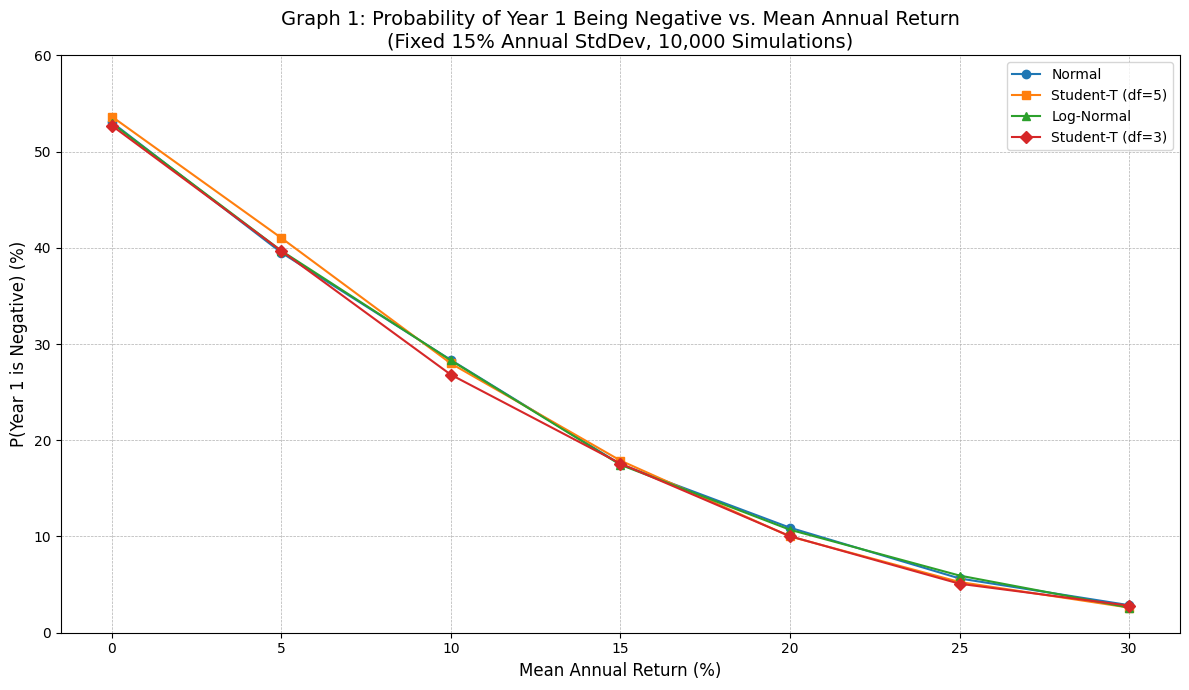

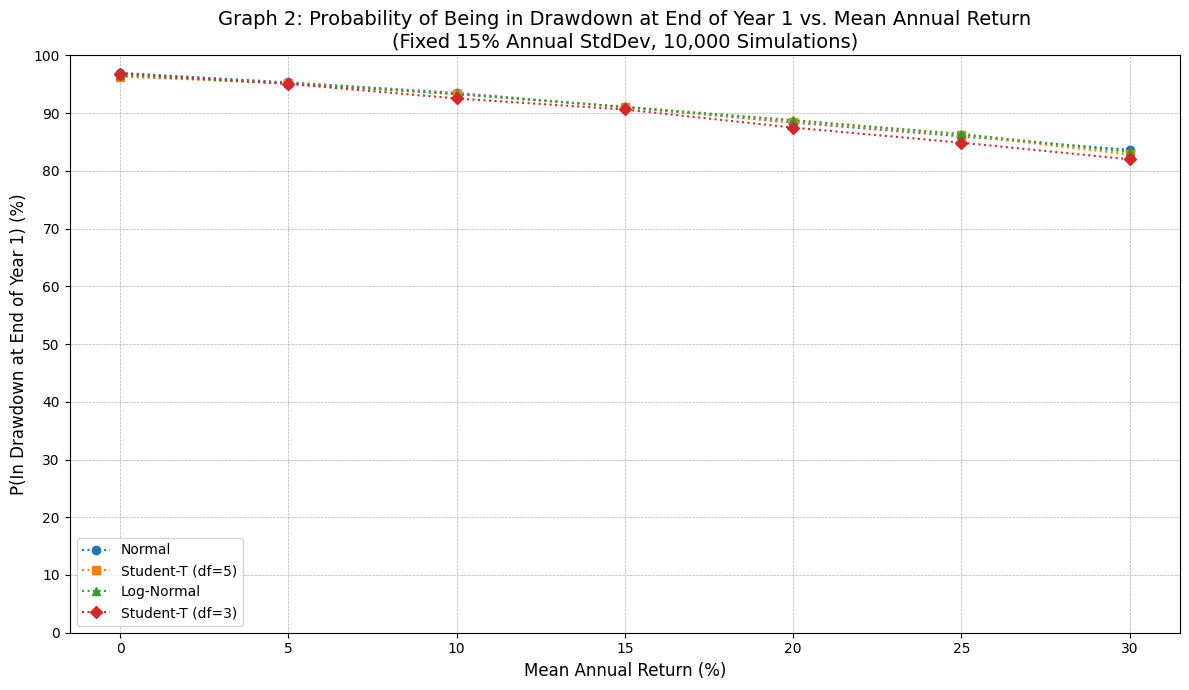


This document presents a detailed Monte Carlo simulation analysis.
The analysis compares four different return distributions (Normal, Student-T (df=5), Log-Normal, Student-T (df=3)) across various mean annual return scenarios, while keeping the annualized standard deviation fixed at 15%. Each scenario is simulated 10000 times over a 10-year horizon using daily data.

**Simulation Parameters:**
* **Distributions Tested:** Normal, Student-T (df=5), Log-Normal, Student-T (df=3)
* **Annualized Standard Deviation (Fixed):** 15%
* **Annualized Mean Returns Tested (for most Tables and Graphs):** 0%, 5%, 10%, 15%, 20%, 25%, 30%
* **Fixed Annualized Mean Return (for Table 1):** 15%
* **Number of Monte Carlo Simulations per Scenario:** 10000
* **Simulation Horizon per Run:** 10 years (2520 daily periods)
* **Days per Year:** 252


---
**Part 1: Likelihood of ANY Given Calendar Year Being Negative (Fixed 15% Mean)**
---
```text
Distribution       | Likelihood Any Year Negative (%) (at 15% Mean)


In [9]:

# --- Prepare Table 1 Output ---
table1_output_str = "Distribution       | Likelihood Any Year Negative (%) (at 15% Mean)\n"
table1_output_str += "-------------------|-------------------------------------------------\n"
for dist_name_h in dist_names_for_header:
    val = prob_any_year_negative_fixed_mean[dist_name_h]
    table1_output_str += f"{dist_name_h:<18} | {val:<47.2f}%\n"

# --- Prepare Table 2 Outputs ---
table2_outputs_str_list = []
for dist_name_h in dist_names_for_header:
    parts = [f"**Table 2: Sequential Negative Years - {dist_name_h} (StdDev 15%)**\n"]
    headers = [f"Mean={m*100:.0f}% (%)" for m in mean_returns_to_test_annual]
    parts.append("Number of Consecutive Negative Years | " + " | ".join(headers))
    parts.append("------------------------------------|-" + "-|-".join(["-----------------" for _ in headers]))
    for k in range(1, num_years_per_run + 1):
        lbl = f"P(First {k} Yr{'s' if k > 1 else ''} Negative)"
        if k == 1: lbl = "P(Year 1 is negative)"
        if k == num_years_per_run: lbl = f"P(All {k} Yrs Negative)"

        row_data_elements = [f"{lbl:<36}"]
        for m_val in mean_returns_to_test_annual:
            m_key = f"{m_val*100:.0f}%"
            prob_val = (sequential_neg_years_counts_varied_mean[dist_name_h][m_key][k-1] / num_monte_carlo_sims * 100)
            is_rare_event_all_neg = (k == num_years_per_run and prob_val < 0.01 and prob_val > 0)
            precision_str = ".4f" if is_rare_event_all_neg else ".2f"
            # Adjust cell width based on whether it's a rare event needing more precision
            cell_width = 17 + (2 if is_rare_event_all_neg else 0)
            row_data_elements.append(f"{prob_val:<{cell_width}{precision_str}}%")
        parts.append(" | ".join(row_data_elements))
    table2_outputs_str_list.append("\n".join(parts))

# --- Prepare Table 3 Outputs ---
table3_outputs_str_list = []
N_years_loss_display = [1, 3, 5, 10]
for dist_name_h in dist_names_for_header:
    parts = [f"**Table 3: Prob. Wealth < Initial Investment - {dist_name_h} (StdDev 15%)**\n"]
    headers = [f"Mean={m*100:.0f}% (%)" for m in mean_returns_to_test_annual]
    parts.append("Years Elapsed | " + " | ".join(headers))
    parts.append("--------------|-"+ "-|-".join(["-----------------" for _ in headers]))
    for N_years in N_years_loss_display:
        row_data = [f"{N_years:<13}"] + [
            f"{(wealth_below_initial_counts[dist_name_h][f'{m*100:.0f}%'][N_years] / num_monte_carlo_sims * 100):<17.2f}%"
            for m in mean_returns_to_test_annual]
        parts.append(" | ".join(row_data))
    table3_outputs_str_list.append("\n".join(parts))

# --- Prepare Table 4 Outputs ---
table4_outputs_str_list = []
for dist_name_h in dist_names_for_header:
    parts = [f"**Table 4: Prob. In Drawdown at End of Year N - {dist_name_h} (StdDev 15%)**\n"]
    headers = [f"Mean={m*100:.0f}% (%)" for m in mean_returns_to_test_annual]
    parts.append("End of Year N | " + " | ".join(headers))
    parts.append("---------------|-"+ "-|-".join(["-----------------" for _ in headers]))
    for k_year_idx in range(num_years_per_run):
        lbl = f"Year {k_year_idx + 1}"
        row_data = [f"{lbl:<14}"] + [
            f"{(prob_in_drawdown_at_year_end_counts[dist_name_h][f'{m*100:.0f}%'][k_year_idx] / num_monte_carlo_sims * 100):<17.2f}%"
            for m in mean_returns_to_test_annual]
        parts.append(" | ".join(row_data))
    table4_outputs_str_list.append("\n".join(parts))

# --- Prepare Table 5 Output ---
table5_output_str_parts = [f"**Table 5: Mean % of Days in Drawdown by Size - Normal Distribution (StdDev 15%)**\n"]
header_cols_t5 = [f"Mean={m*100:.0f}% (%)" for m in mean_returns_to_test_annual]
table5_output_str_parts.append("Drawdown Size (%) | " + " | ".join(header_cols_t5))
table5_output_str_parts.append("------------------|-" + "-|-".join(["-----------------" for _ in header_cols_t5]))
for thresh_idx, dd_thresh_decimal in enumerate(drawdown_size_thresholds_for_table5):
    dd_thresh_percent_label = f"{dd_thresh_decimal*100:.1f}%"
    row_data = [f"{dd_thresh_percent_label:<17}"] + [
        f"{(days_in_drawdown_by_size_sum_normal[f'{m*100:.0f}%'][thresh_idx] / num_monte_carlo_sims):<17.2f}%"
        for m in mean_returns_to_test_annual ]
    table5_output_str_parts.append(" | ".join(row_data))
table5_output_str = "\n".join(table5_output_str_parts)

# --- NEW: Prepare Table 6 (CVaR 5% of Annual Returns) ---
table6_outputs_str_list = []
for dist_name_h in dist_names_for_header:
    parts = [f"**Table 6: CVaR (5%) of Annual Returns - {dist_name_h} (StdDev 15%)**\n"]
    headers = [f"Mean={m*100:.0f}%" for m in mean_returns_to_test_annual]
    parts.append("CVaR (5%)     | " + " | ".join(headers)) # Header for data type
    parts.append("--------------|-" + "-|-".join(["-----------------" for _ in headers]))
    row_data_cvar = ["Value (%)     "] # Row label
    for mean_val in mean_returns_to_test_annual:
        mean_key = f"{mean_val*100:.0f}%"
        # Calculate CVaR from the collected annual returns for this scenario
        cvar_val = calculate_cvar(np.array(all_annual_returns_for_cvar[dist_name_h][mean_key]), alpha=0.05)
        row_data_cvar.append(f"{cvar_val*100:<17.2f}%")
    parts.append(" | ".join(row_data_cvar))
    table6_outputs_str_list.append("\n".join(parts))

# --- NEW: Prepare Table 7 (Longest Run of Negative Annual Years) ---
table7_outputs_str_list = []
for dist_name_h in dist_names_for_header:
    parts = [f"**Table 7: Longest Run of Consecutive Negative Calendar Years - {dist_name_h} (StdDev 15%)**\n"]
    headers = [f"Mean={m*100:.0f}%" for m in mean_returns_to_test_annual]
    parts.append("Statistic     | " + " | ".join(headers))
    parts.append("--------------|-" + "-|-".join(["-----------------" for _ in headers]))
    # Average Longest Run
    row_data_avg_run = ["Avg Length(Yrs)"]
    for mean_val in mean_returns_to_test_annual:
        mean_key = f"{mean_val*100:.0f}%"
        avg_run = np.mean(longest_neg_run_all_sims[dist_name_h][mean_key])
        row_data_avg_run.append(f"{avg_run:<17.2f}")
    parts.append(" | ".join(row_data_avg_run))
    # 95th Percentile Longest Run
    row_data_p95_run = ["P95 Length(Yrs)"]
    for mean_val in mean_returns_to_test_annual:
        mean_key = f"{mean_val*100:.0f}%"
        p95_run = np.percentile(longest_neg_run_all_sims[dist_name_h][mean_key], 95)
        row_data_p95_run.append(f"{p95_run:<17.0f}")
    parts.append(" | ".join(row_data_p95_run))
    table7_outputs_str_list.append("\n".join(parts))

# --- NEW: Prepare Table 8 (Prob. of Max Drawdown > X% during 10 Yrs) ---
table8_outputs_str_list = []
for dist_name_h in dist_names_for_header:
    parts = [f"**Table 8: Prob. of Max Drawdown > Threshold During 10 Years - {dist_name_h} (StdDev 15%)**\n"]
    headers = [f"Mean={m*100:.0f}% (%)" for m in mean_returns_to_test_annual]
    parts.append("Max DD Threshold | " + " | ".join(headers))
    parts.append("-----------------|-" + "-|-".join(["-----------------" for _ in headers]))
    for thresh_idx_t8, dd_thresh_t8_val in enumerate(max_dd_thresholds_table8):
        thresh_label = f"> {dd_thresh_t8_val*100:.0f}%"
        row_data_max_dd = [f"{thresh_label:<16}"]
        for mean_val in mean_returns_to_test_annual:
            mean_key = f"{mean_val*100:.0f}%"
            prob_exceed = (prob_max_dd_exceeds_thresh_counts[dist_name_h][mean_key][thresh_idx_t8] / num_monte_carlo_sims) * 100
            row_data_max_dd.append(f"{prob_exceed:<17.2f}%")
        parts.append(" | ".join(row_data_max_dd))
    table8_outputs_str_list.append("\n".join(parts))


# --- Generate Graph 1 Plot ---
plt.figure(figsize=(12, 7))
mean_returns_percent_axis = mean_returns_to_test_annual * 100
markers = ['o', 's', '^', 'D']
for i, dist_name_h in enumerate(dist_names_for_header):
    y_values_for_graph1 = (prob_year1_neg_vs_mean_for_graph[dist_name_h] / num_monte_carlo_sims) * 100.0
    plt.plot(mean_returns_percent_axis, y_values_for_graph1, marker=markers[i % len(markers)], linestyle='-', label=dist_name_h)
plt.title('Graph 1: Probability of Year 1 Being Negative vs. Mean Annual Return\n(Fixed 15% Annual StdDev, 10,000 Simulations)', fontsize=14)
plt.xlabel('Mean Annual Return (%)', fontsize=12); plt.ylabel('P(Year 1 is Negative) (%)', fontsize=12)
plt.xticks(mean_returns_percent_axis)
## Dynamically set y_ticks based on data range for graph 1
y_max_g1 = 0
# Check if any array in the dictionary values contains any non-zero elements
if any(np.any(arr) for arr in prob_year1_neg_vs_mean_for_graph.values()):
    all_y_g1 = np.concatenate([ (prob_year1_neg_vs_mean_for_graph[d_name] / num_monte_carlo_sims) * 100.0 for d_name in dist_names_for_header])
    if all_y_g1.size > 0 : y_max_g1 = np.ceil(np.max(all_y_g1) / 10.0) * 10 # Round up to next 10
    if y_max_g1 < 50: y_max_g1 = 50 # Ensure a reasonable minimum y-axis scale
plt.yticks(np.arange(0, y_max_g1 + 10, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5); plt.legend(fontsize=10); plt.tight_layout()
img_buffer_graph1 = io.BytesIO(); plt.savefig(img_buffer_graph1, format='png', dpi=100); img_buffer_graph1.seek(0); plt.show(); plt.close()

# --- Generate Graph 2 Plot ---
plt.figure(figsize=(12, 7))
for i, dist_name_h in enumerate(dist_names_for_header):
    y_values_for_graph2 = (prob_in_dd_year1_vs_mean_for_graph[dist_name_h] / num_monte_carlo_sims) * 100.0
    plt.plot(mean_returns_percent_axis, y_values_for_graph2, marker=markers[i % len(markers)], linestyle=':', label=dist_name_h)
plt.title('Graph 2: Probability of Being in Drawdown at End of Year 1 vs. Mean Annual Return\n(Fixed 15% Annual StdDev, 10,000 Simulations)', fontsize=14)
plt.xlabel('Mean Annual Return (%)', fontsize=12); plt.ylabel('P(In Drawdown at End of Year 1) (%)', fontsize=12)
plt.xticks(mean_returns_percent_axis)
# Dynamically set y_ticks based on data range for graph 2
y_max_g2 = 0
# Check if any array in the dictionary values contains any non-zero elements
if any(np.any(arr) for arr in prob_in_dd_year1_vs_mean_for_graph.values()): # Check if data exists
    all_y_g2 = np.concatenate([ (prob_in_dd_year1_vs_mean_for_graph[d_name] / num_monte_carlo_sims) * 100.0 for d_name in dist_names_for_header])
    if all_y_g2.size > 0 : y_max_g2 = np.ceil(np.max(all_y_g2) / 10.0) * 10
    if y_max_g2 < 50: y_max_g2 = 50
plt.yticks(np.arange(0, y_max_g2 + 10, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5); plt.legend(fontsize=10); plt.tight_layout()
img_buffer_graph2 = io.BytesIO(); plt.savefig(img_buffer_graph2, format='png', dpi=100); img_buffer_graph2.seek(0); plt.show(); plt.close()

# --- Consolidate all text output ---
output_parts = []
sd_fixed_display_val = int(fixed_annual_std_dev_config * 100)
mean_returns_tested_display_list = [f"{int(m*100)}%" for m in mean_returns_to_test_annual]
mean_returns_tested_display_str = ', '.join(mean_returns_tested_display_list)
fixed_mean_table1_display_val = int(fixed_15_pct_mean_annual * 100)

output_parts.append(f"""
This document presents a detailed Monte Carlo simulation analysis.
The analysis compares four different return distributions ({', '.join(dist_names_for_header)}) across various mean annual return scenarios, while keeping the annualized standard deviation fixed at 15%. Each scenario is simulated {num_monte_carlo_sims} times over a 10-year horizon using daily data.

**Simulation Parameters:**
* **Distributions Tested:** {', '.join(dist_names_for_header)}
* **Annualized Standard Deviation (Fixed):** {sd_fixed_display_val}%
* **Annualized Mean Returns Tested (for most Tables and Graphs):** {mean_returns_tested_display_str}
* **Fixed Annualized Mean Return (for Table 1):** {fixed_mean_table1_display_val}%
* **Number of Monte Carlo Simulations per Scenario:** {num_monte_carlo_sims}
* **Simulation Horizon per Run:** {num_years_per_run} years ({num_total_daily_periods_per_run} daily periods)
* **Days per Year:** {num_trading_days_per_year}
""")
output_parts.append(f"\n---\n**Part 1: Likelihood of ANY Given Calendar Year Being Negative (Fixed 15% Mean)**\n---\n```text\n{table1_output_str}```")
output_parts.append("\n---\n**Part 2: Likelihood of Sequential Negative Calendar Years (Varying Means 0-30%)**\n---")
output_parts.extend(table2_outputs_str_list)
output_parts.append("\n---\n**Part 3: Graph 1 - Probability of Year 1 Being Negative vs. Mean Annual Return**\n---\n*(Graph 1 image will be displayed here)*")
output_parts.append("\n---\n**Part 4: Probability of Wealth Below Initial Investment (Varying Means 0-30%)**\n---")
output_parts.extend(table3_outputs_str_list)
output_parts.append("\n---\n**Part 5: Probability of Being in Drawdown at End of Year N (Varying Means 0-30%)**\n---")
output_parts.extend(table4_outputs_str_list)
output_parts.append("\n---\n**Part 6: Graph 2 - Probability of Being in Drawdown at End of Year 1 vs. Mean Annual Return**\n--- \n*(Graph 2 image will be displayed here)*")
output_parts.append("\n---\n**Part 7: Mean Percentage of Days in Drawdown by Size - Normal Distribution (Varying Means 0-30%)**\n---\n```text\n{table5_output_str}```")
output_parts.append("\n---\n**Part 8: CVaR (5%) of Annual Returns (Varying Means 0-30%)**\n---")
output_parts.extend(table6_outputs_str_list)
output_parts.append("\n---\n**Part 9: Longest Run of Consecutive Negative Calendar Years (Varying Means 0-30%)**\n---")
output_parts.extend(table7_outputs_str_list)
output_parts.append("\n---\n**Part 10: Probability of Max Drawdown > Threshold During 10 Years (Varying Means 0-30%)**\n---")
output_parts.extend(table8_outputs_str_list)

output_parts.append(f"""
\n**Instructions for Pasting Tables into Excel:**
1. Copy the desired table block.
2. Paste into Excel. Use 'Data' -> 'Text to Columns' with '|' as delimiter if needed.

Analysis complete.
""")
final_markdown_output = "\n".join(output_parts)
print(final_markdown_output)